In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import ICRS

from galpy.potential import evaluatePotentials,evaluateRforces,evaluatezforces,mass,vcirc,LogarithmicHaloPotential,MiyamotoNagaiPotential,HernquistPotential,DiskSCFPotential,NFWPotential,SCFPotential,mwpot_helpers,scf_compute_coeffs_axi
from galpy.potential.mwpotentials import McMillan17,MWPotential2014
from galpy.orbit import Orbit
from galpy.util import conversion
from GalPot import GalaxyPotential
import gala.potential as gp
from gala.units import UnitSystem
from dustmaps.gaia_tge import GaiaTGEQuery
from zero_point import zpt
%matplotlib inline

# define colormap for all the density plots
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

## A1.1. Reproduction of Helmi et al. (2018)

In [2]:
# load Gaia DR2 6D data with parallax_over_error > 5
path_ge='data/GaiaDR2_6D_paroverr_5.fits'

hdu_list_ge = fits.open(path_ge, memmap=True)
data_ge = Table(hdu_list_ge[1].data)
hdu_list_ge.close()
data_ge

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,l,b,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,radial_velocity,radial_velocity_error,phot_bp_rp_excess_factor
int64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float32
2021659939697145728,295.2736692126975,0.012891017502583247,25.330212432523595,0.01682641293852304,2.1587254165453444,0.021978824691060835,98.21842,-13.992715222049894,0.03179828287693372,-12.799978783796927,0.035195900160036264,60.93275623833162,1.2693896533258162,13.362812,13.7905035,12.782986,10.085115397627476,5.955380543867405,1.2211567
2021663684908695296,295.23525035606076,0.021139806888629282,25.43384035016541,0.02840551727549998,0.40121629454859725,0.0375403408631866,10.687604,-3.794795555643248,0.053140214655370034,-7.407957074366008,0.05836963561027636,61.00573043190996,1.3507597932179924,13.625554,15.256229,12.389916,-29.472448783488836,0.541008060583523,1.4927461
5781854874748191360,235.2106394494379,0.01924171147196387,-75.47308655370539,0.01869449866243966,0.18961613801783872,0.024175910370446214,7.843185,-5.310135698494684,0.03365674360434923,-3.329038050885634,0.03732737835279162,313.0589816808438,-16.04695059509058,12.836737,13.770793,11.897108,0.41460504827570754,0.6720702940869024,1.3223766
1872306570816130048,316.02264365817075,0.020916187231681923,39.27187530542963,0.022772443381162837,0.7573922377204895,0.028743435236558805,26.350094,-12.216182242227962,0.04155967786189707,-20.268327452662348,0.041850006903107695,82.34559651221542,-5.063172397434475,12.782377,13.510119,11.962825,-24.247496491168647,1.4294989841541506,1.2813091
5781847594782284544,237.0618565288048,0.019102513738817477,-75.03130017021289,0.020773361557865164,0.8619811896011716,0.024747007330313257,34.831734,-4.655927040276303,0.03681828460683597,-5.598360337083744,0.04372801099978177,313.7295640513117,-16.004739380109935,10.376277,11.157188,9.550671,-3.958332724782773,1.5481840583882223,1.2684513
4464060403258830208,246.04280488080929,0.017273659401025734,14.710615059364866,0.012704776376138361,0.4264712699368664,0.027220456302458187,15.667308,-6.179033352858108,0.03442121043089624,-13.960854851910266,0.02878677170763798,30.100699590874495,39.17124139238024,12.531325,13.060503,11.864857,97.47166748871939,0.8392385341088069,1.2373995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6680787617084077184,307.39564490342127,0.041899108676670925,-39.814355890604794,0.025986823095450976,10.841612923362796,0.06864670638013527,157.93347,-90.51078979834094,0.08905405312677762,-69.00792020544388,0.05485686888156068,1.6582823652880927,-35.15937379762024,10.536817,11.047237,9.89869,45.92740431050175,0.8947018917326944,1.2249678
6680694227315006336,307.26542359584624,0.03206670800044378,-40.60701001262355,0.019125887248372976,0.3281031599873426,0.0415053572146979,7.90508,5.066364148359448,0.06175321809753691,-3.9972995958684363,0.042709010295729086,0.6811370592092802,-35.1677011050817,12.261007,12.987221,11.449331,51.77689966007245,0.375323909288443,1.275287


In [3]:
ra_ge = data_ge['ra'] # in deg
dec_ge = data_ge['dec'] # in deg
paral_ge = data_ge['parallax'] # in mas
pmra_ge = data_ge['pmra'] # in mas/yr
pmdec_ge = data_ge['pmdec'] # in mas/y
rad_vel_ge = data_ge['radial_velocity'] # in km/s

ra_rad=(ra_ge/360)*2*np.pi
dec_rad=(dec_ge/360)*2*np.pi
alphag=(192.85948/360)*2*np.pi
deltag=(27.12825/360)*2*np.pi
l_ngp=(122.93192/360)*2*np.pi
k=4.74057

# add Sun parameters (needed to remove non-halo stars and later to scale plots by Sun
r_gc_sun=np.array([-8122,0,20.8])*u.pc # in pc
v_gc_sun=np.array([-11.1,12.24+232.8,7.25])*u.km/u.s # in km/s
R_sun = np.sqrt(r_gc_sun[0]**2+r_gc_sun[1]**2)
L_sun=np.cross(r_gc_sun,v_gc_sun)/1000 # in kpc*km/s
L_z_sun=np.transpose(L_sun)[2]
E_sun=evaluatePotentials(McMillan17,np.sqrt(r_gc_sun[1]**2+r_gc_sun[1]**2),r_gc_sun[2])
orb_E_sun = np.array((v_gc_sun[0]**2+v_gc_sun[1]**2+v_gc_sun[2]**2)/2) + E_sun

#######################################################################
# apply condition |v-v_lsr| > 210 km/s for halo stars and only proceed with what's left
# convert to galactocentric coordinates
gc_sel=coord.SkyCoord(ICRS(ra=data_ge['ra']*u.degree,dec=data_ge['dec']*u.degree,distance=(1000/data_ge['parallax'])*u.pc,pm_ra_cosdec=data_ge['pmra']*np.cos((data_ge['dec']/360)*2*np.pi)*u.mas/u.yr,pm_dec=data_ge['pmdec']*u.mas/u.yr,radial_velocity=data_ge['radial_velocity']*u.km/u.s)).transform_to(coord.Galactocentric)

# determine GC velocities via Johnson & Soderblom (1987)
t1=np.array([[np.cos(l_ngp),np.sin(l_ngp),0],[np.sin(l_ngp),-np.cos(l_ngp),0],[0,0,1]])
t2=np.array([[-np.sin(deltag),0,np.cos(deltag)],[0,-1,0],[np.cos(deltag),0,np.sin(deltag)]])
t3=np.array([[np.cos(alphag),np.sin(alphag),0],[np.sin(alphag),-np.cos(alphag),0],[0,0,1]])
T=t1.dot(t2.dot(t3))
A=np.array([[np.cos(ra_rad)*np.cos(dec_rad),-np.sin(ra_rad),-np.cos(ra_rad)*np.sin(dec_rad)],[np.sin(ra_rad)*np.cos(dec_rad),np.cos(ra_rad),-np.sin(ra_rad)*np.sin(dec_rad)],[np.sin(dec_rad),np.zeros(len(ra_rad)),np.cos(dec_rad)]])
B=np.transpose(T.dot(np.transpose(A,axes=(1,0,2))),axes=(2,0,1))
icrs_vel=np.transpose(np.array([rad_vel_ge,k*pmra_ge*np.cos(dec_rad)/paral_ge,k*pmdec_ge/paral_ge]))
v_gc = np.transpose(np.einsum('ijk,ik->ij',B,icrs_vel))
v_gc_ge = np.array([-v_gc[0]-11.1,v_gc[1]+12.24+232.8,v_gc[2]+7.25])*u.km/u.s
data_ge = data_ge[np.sqrt(v_gc_ge[0]**2+(v_gc_ge[1]-232*u.km/u.s)**2+v_gc_ge[2]**2) > 210*u.km/u.s]
#######################################################################

# now start over with reduced dataset
ra_ge = data_ge['ra'] # in deg
dec_ge = data_ge['dec'] # in deg
paral_ge = data_ge['parallax'] # in mas
paral_e_ge = data_ge['parallax_error'] # in mas
pmra_ge = data_ge['pmra'] # in mas/yr
pmra_e_ge = data_ge['pmra_error'] # in mas/yr
pmdec_ge = data_ge['pmdec'] # in mas/y
pmdec_e_ge = data_ge['pmdec_error'] # in mas/yr
rad_vel_ge = data_ge['radial_velocity'] # in km/s
rad_vel_e_ge = data_ge['radial_velocity_error'] # in km/s
bprp_excess = data_ge['phot_bp_rp_excess_factor']
l_ge = data_ge['l'] # in deg
b_ge = data_ge['b'] # in deg

data_ge=[] # free up RAM space

# using astropy get full cartesian coordinates for position and velocity
astrom_ge=ICRS(ra=ra_ge*u.degree,dec=dec_ge*u.degree,distance=(1000/paral_ge)*u.pc,pm_ra_cosdec=pmra_ge*np.cos((dec_ge/360)*2*np.pi)*u.mas/u.yr,pm_dec=pmdec_ge*u.mas/u.yr,radial_velocity=rad_vel_ge*u.km/u.s)
# convert to galactocentric coordinates
gc_ge=coord.SkyCoord(astrom_ge).transform_to(coord.Galactocentric)

#NOTE: astropy is right-handed, galpy and kinematic analyses in general left-handed
# for now I put -gc.x and -gc.v_x instead of gc.x and gc.v_x as solution
gcx_ge=-gc_ge.x
gcvx_ge=-gc_ge.v_x

r_gc_ge=np.transpose(np.array([gcx_ge,gc_ge.y,gc_ge.z])) # in pc
v_gc_ge=np.transpose(np.array([gcvx_ge,gc_ge.v_y,gc_ge.v_z])) # in km/s

# determine GC velocities via Johnson & Soderblom (1987) instead of using the astropy velocities
ra_rad=(ra_ge/360)*2*np.pi
dec_rad=(dec_ge/360)*2*np.pi

alphag=(192.85948/360)*2*np.pi
deltag=(27.12825/360)*2*np.pi
l_ngp=(122.93192/360)*2*np.pi
k=4.74057

t1=np.array([[np.cos(l_ngp),np.sin(l_ngp),0],[np.sin(l_ngp),-np.cos(l_ngp),0],[0,0,1]])
t2=np.array([[-np.sin(deltag),0,np.cos(deltag)],[0,-1,0],[np.cos(deltag),0,np.sin(deltag)]])
t3=np.array([[np.cos(alphag),np.sin(alphag),0],[np.sin(alphag),-np.cos(alphag),0],[0,0,1]])
T=t1.dot(t2.dot(t3))
A=np.array([[np.cos(ra_rad)*np.cos(dec_rad),-np.sin(ra_rad),-np.cos(ra_rad)*np.sin(dec_rad)],[np.sin(ra_rad)*np.cos(dec_rad),np.cos(ra_rad),-np.sin(ra_rad)*np.sin(dec_rad)],[np.sin(dec_rad),np.zeros(len(ra_rad)),np.cos(dec_rad)]])
B=np.transpose(T.dot(np.transpose(A,axes=(1,0,2))),axes=(2,0,1))
icrs_vel=np.transpose(np.array([rad_vel_ge,k*pmra_ge*np.cos(dec_rad)/paral_ge,k*pmdec_ge/paral_ge]))
v_gc = np.transpose(np.einsum('ijk,ik->ij',B,icrs_vel))
v_gc_ge = np.transpose([-v_gc[0]-11.1,v_gc[1]+12.24+232.8,v_gc[2]+7.25])
cond_v = (np.sqrt(np.transpose(v_gc_ge)[0]**2+(np.transpose(v_gc_ge)[1]-232)**2+np.transpose(v_gc_ge)[2]) > 210)

# Galactocentric distance in disk plane
R_ge = np.sqrt(np.transpose(r_gc_ge)[0]**2+np.transpose(r_gc_ge)[1]**2)*u.pc
z_ge = np.transpose(r_gc_ge)[2]*u.pc

# absolute space velocities, v_y and v_perp to y
v_tot_ge=np.sqrt(np.transpose(v_gc_ge)[0]**2+np.transpose(v_gc_ge)[1]**2+np.transpose(v_gc_ge)[2]**2)*u.km/u.s
v_y_ge=np.transpose(v_gc_ge)[1]*u.km/u.s
v_zx_ge=np.sqrt(np.transpose(v_gc_ge)[0]**2+np.transpose(v_gc_ge)[2]**2)*u.km/u.s

# angular momentum L=rxv
L_ge=np.cross(r_gc_ge,v_gc_ge)/1000 # in kpc*km/s
L_x_ge=np.transpose(L_ge)[0]
L_y_ge=np.transpose(L_ge)[1]
L_z_ge=np.transpose(L_ge)[2]
L_perp_ge=np.sqrt(L_x_ge**2+L_y_ge**2)

# get potentials and energies using a logarithmic halo, a Miyamoto-Nagai disk and a Hernquist bulge (see Helmi et al. 2017)
# model parameters
v_halo=173.2*u.km/u.s
d=12000*u.pc
G=4.3*10**(-3)*u.pc/u.Msun*(u.km/u.s)**2
M_disk=6.3*10**10*u.Msun
a_d=6500*u.pc
b_d=260*u.pc
M_bulge=2.1*10**10*u.Msun
c_b=700*u.pc

# three different ways of computation, all have same result so doesn't matter which one is used
########################## GALPY python package #####################
# for log. halo need to substract amp*ln(12000/8000) due to slightly different functional form in galpy
# for bulge need to multiply by 2 due to factor 2 difference in galpy
# potential at centre of MW as zero-point offset
phi_halo_0=evaluatePotentials(LogarithmicHaloPotential(amp=v_halo**2*2,core=d),0,0) - 2*np.array(v_halo)**2*np.log(12000/8000)
phi_disk_0=evaluatePotentials(MiyamotoNagaiPotential(amp=G*M_disk,a=a_d,b=b_d),0,0)
phi_bulge_0=evaluatePotentials(HernquistPotential(amp=G*M_bulge,a=c_b),0,0)*2
phi_total_0=phi_halo_0+phi_disk_0+phi_bulge_0

# calculate potentials and energies for whole dataset and add zero-point offset
phi_halo=evaluatePotentials(LogarithmicHaloPotential(amp=v_halo**2*2,core=d),R_ge,z_ge) - 2*np.array(v_halo)**2*np.log(12000/8000)
phi_disk=evaluatePotentials(MiyamotoNagaiPotential(amp=G*M_disk,a=a_d,b=b_d),R_ge,z_ge)
phi_bulge=evaluatePotentials(HernquistPotential(amp=G*M_bulge,a=c_b),R_ge,z_ge)*2
phi_total=phi_halo+phi_disk+phi_bulge + phi_total_0
orb_E_H17 = np.array(v_tot_ge)**2/2 + phi_total

# potential and energy of Sun
phi_halo_sun=evaluatePotentials(LogarithmicHaloPotential(amp=v_halo**2*2,core=d),R_sun,r_gc_sun[2]) - 2*np.array(v_halo)**2*np.log(12000/8000)
phi_disk_sun=evaluatePotentials(MiyamotoNagaiPotential(amp=G*M_disk,a=a_d,b=b_d),R_sun,r_gc_sun[2])
phi_bulge_sun=evaluatePotentials(HernquistPotential(amp=G*M_bulge,a=c_b),R_sun,r_gc_sun[2])*2
phi_total_sun=phi_halo_sun+phi_disk_sun+phi_bulge_sun + phi_total_0
orb_E_sun = np.array(v_gc_sun.dot(v_gc_sun))/2 + np.array(phi_total_sun)

################## GALA PYTHON PACKAGE #######################
usys1=UnitSystem(u.pc,u.Myr,u.Msun,u.degree)
usys2=UnitSystem(u.km,u.s,u.kg,u.degree)
lhp=gp.LogarithmicPotential(v_c=v_halo.decompose(usys1)*np.sqrt(2),r_h=1,q1=12000,q2=12000,q3=12000,units=usys1)
mnp=gp.MiyamotoNagaiPotential(m=M_disk,a=a_d,b=b_d,units=usys1)
hqp=gp.HernquistPotential(m=M_bulge,c=c_b,units=usys1)

# potential at centre of MW as zero-point offset
phi_halo_0=lhp.energy([0,0,0]).decompose(usys2)
phi_disk_0=mnp.energy([0,0,0]).decompose(usys2)
phi_bulge_0=hqp.energy([0,0,0]).decompose(usys2)
phi_total_0=phi_halo_0+phi_disk_0+phi_bulge_0

# calculate potentials and energies for whole dataset and add zero-point offset
phi_halo=lhp.energy([np.transpose(r_gc_ge)[0],np.transpose(r_gc_ge)[1],np.transpose(r_gc_ge)[2]]).decompose(usys2)
phi_disk=mnp.energy([np.transpose(r_gc_ge)[0],np.transpose(r_gc_ge)[1],np.transpose(r_gc_ge)[2]]).decompose(usys2)
phi_bulge=hqp.energy([np.transpose(r_gc_ge)[0],np.transpose(r_gc_ge)[1],np.transpose(r_gc_ge)[2]]).decompose(usys2)
phi_total=phi_halo+phi_disk+phi_bulge + phi_total_0
orb_E_H17 = v_tot_ge**2/2 + phi_total

# potential and energy of Sun
phi_halo_sun=lhp.energy([np.array(r_gc_sun[0]),np.array(r_gc_sun[1]),np.array(r_gc_sun[2])]).decompose(usys2)
phi_disk_sun=mnp.energy([np.array(r_gc_sun[0]),np.array(r_gc_sun[1]),np.array(r_gc_sun[2])]).decompose(usys2)
phi_bulge_sun=hqp.energy([np.array(r_gc_sun[0]),np.array(r_gc_sun[1]),np.array(r_gc_sun[2])]).decompose(usys2)
phi_total_sun=phi_halo_sun+phi_disk_sun+phi_bulge_sun + phi_total_0
orb_E_sun = np.array(v_gc_sun.dot(v_gc_sun))/2 + np.array(phi_total_sun)

################### DIRECTLY PLUGGING INTO FORMULA #################
# potential at centre of MW as zero-point offset
phi_halo_0 = v_halo**2*np.log(1+np.array(0**2/d**2+0**2/d**2)) # logarithmic halo; (km/s)^2
phi_disk_0 = -G*M_disk/np.sqrt(0**2+(a_d+np.sqrt(0**2+b_d**2))**2) # Miyamoto-Nagai disk; (km/s)^2
phi_bulge_0 = -G*M_bulge/(np.sqrt(0**2+0**2+0**2)+c_b) # Hernquist bulge; (km/s)
phi_total_0 = phi_halo_0+phi_disk_0+phi_bulge_0

# calculate potentials and energies for whole dataset and add zero-point offset
phi_halo = v_halo**2*np.log(1+R_ge**2/d**2+z_ge**2/d**2) # logarithmic halo; (km/s)^2
phi_disk = -G*M_disk/np.sqrt(R_ge**2+(a_d+np.sqrt(z_ge**2+b_d**2))**2) # Miyamoto-Nagai disk; (km/s)^2
phi_bulge = -G*M_bulge/(np.sqrt(gc_ge.x**2+gc_ge.y**2+z_ge**2)+c_b) # Hernquist bulge; (km/s)
phi_total = phi_halo+phi_disk+phi_bulge + phi_total_0
orb_E_H17 = v_tot_ge**2/2 + phi_total

# potential and energy of Sun
phi_halo_sun = v_halo**2*np.log(1+R_sun**2/d**2+r_gc_sun[2]**2/d**2) # logarithmic halo; (km/s)^2
phi_disk_sun = -G*M_disk/np.sqrt(R_sun**2+(a_d+np.sqrt(r_gc_sun[2]**2+b_d**2))**2) # Miyamoto-Nagai disk; (km/s)^2
phi_bulge_sun = -G*M_bulge/(np.sqrt(r_gc_sun[0]**2+r_gc_sun[1]**2+r_gc_sun[2]**2)+c_b) # Hernquist bulge; (km/s)
phi_total_sun = phi_halo_sun+phi_disk_sun+phi_bulge_sun + phi_total_0
orb_E_sun = np.array(v_gc_sun.dot(v_gc_sun))/2 + np.array(phi_total_sun)

# if I want to use McMillan 2017 instead
# potentials and circular velocity using GalPot
Phi_M17 = GalaxyPotential("data/catalogues/PJM17_best.Tpot")

# potential in km^2/s^2
Phi_ge_M17=Phi_M17.Potential(np.array(R_ge)/1000,np.array(z_ge)/1000)*Phi_M17.kpc_Myr_to_km_s**2*(u.km/u.s)**2
orb_E_ge=v_tot_ge**2/2+Phi_ge_M17

/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)

/home/jens/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)



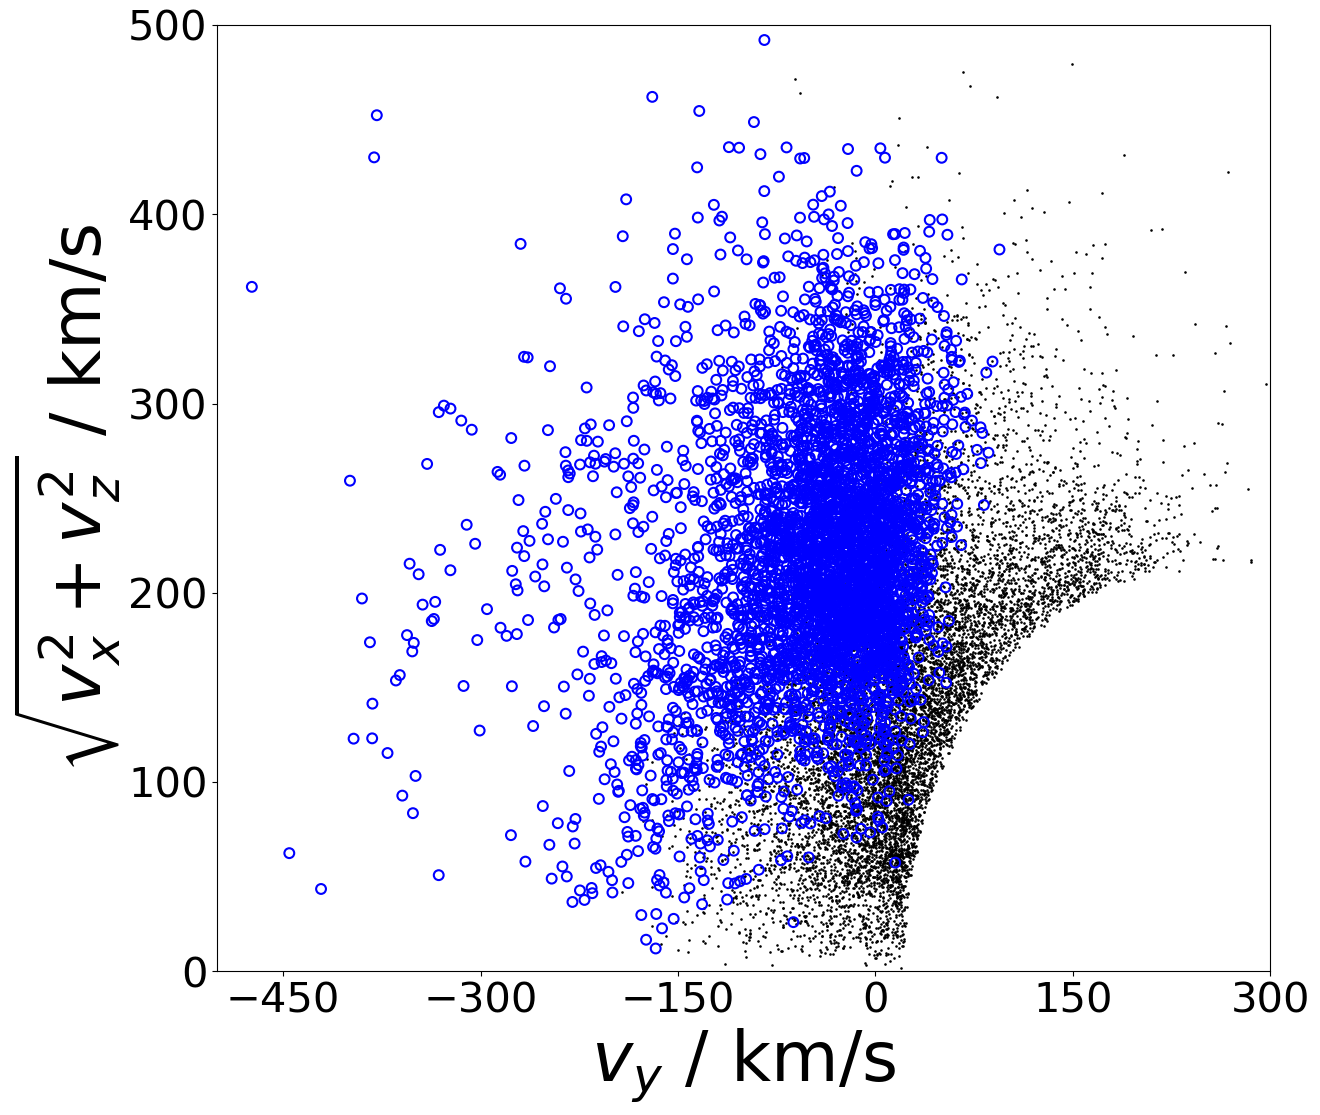

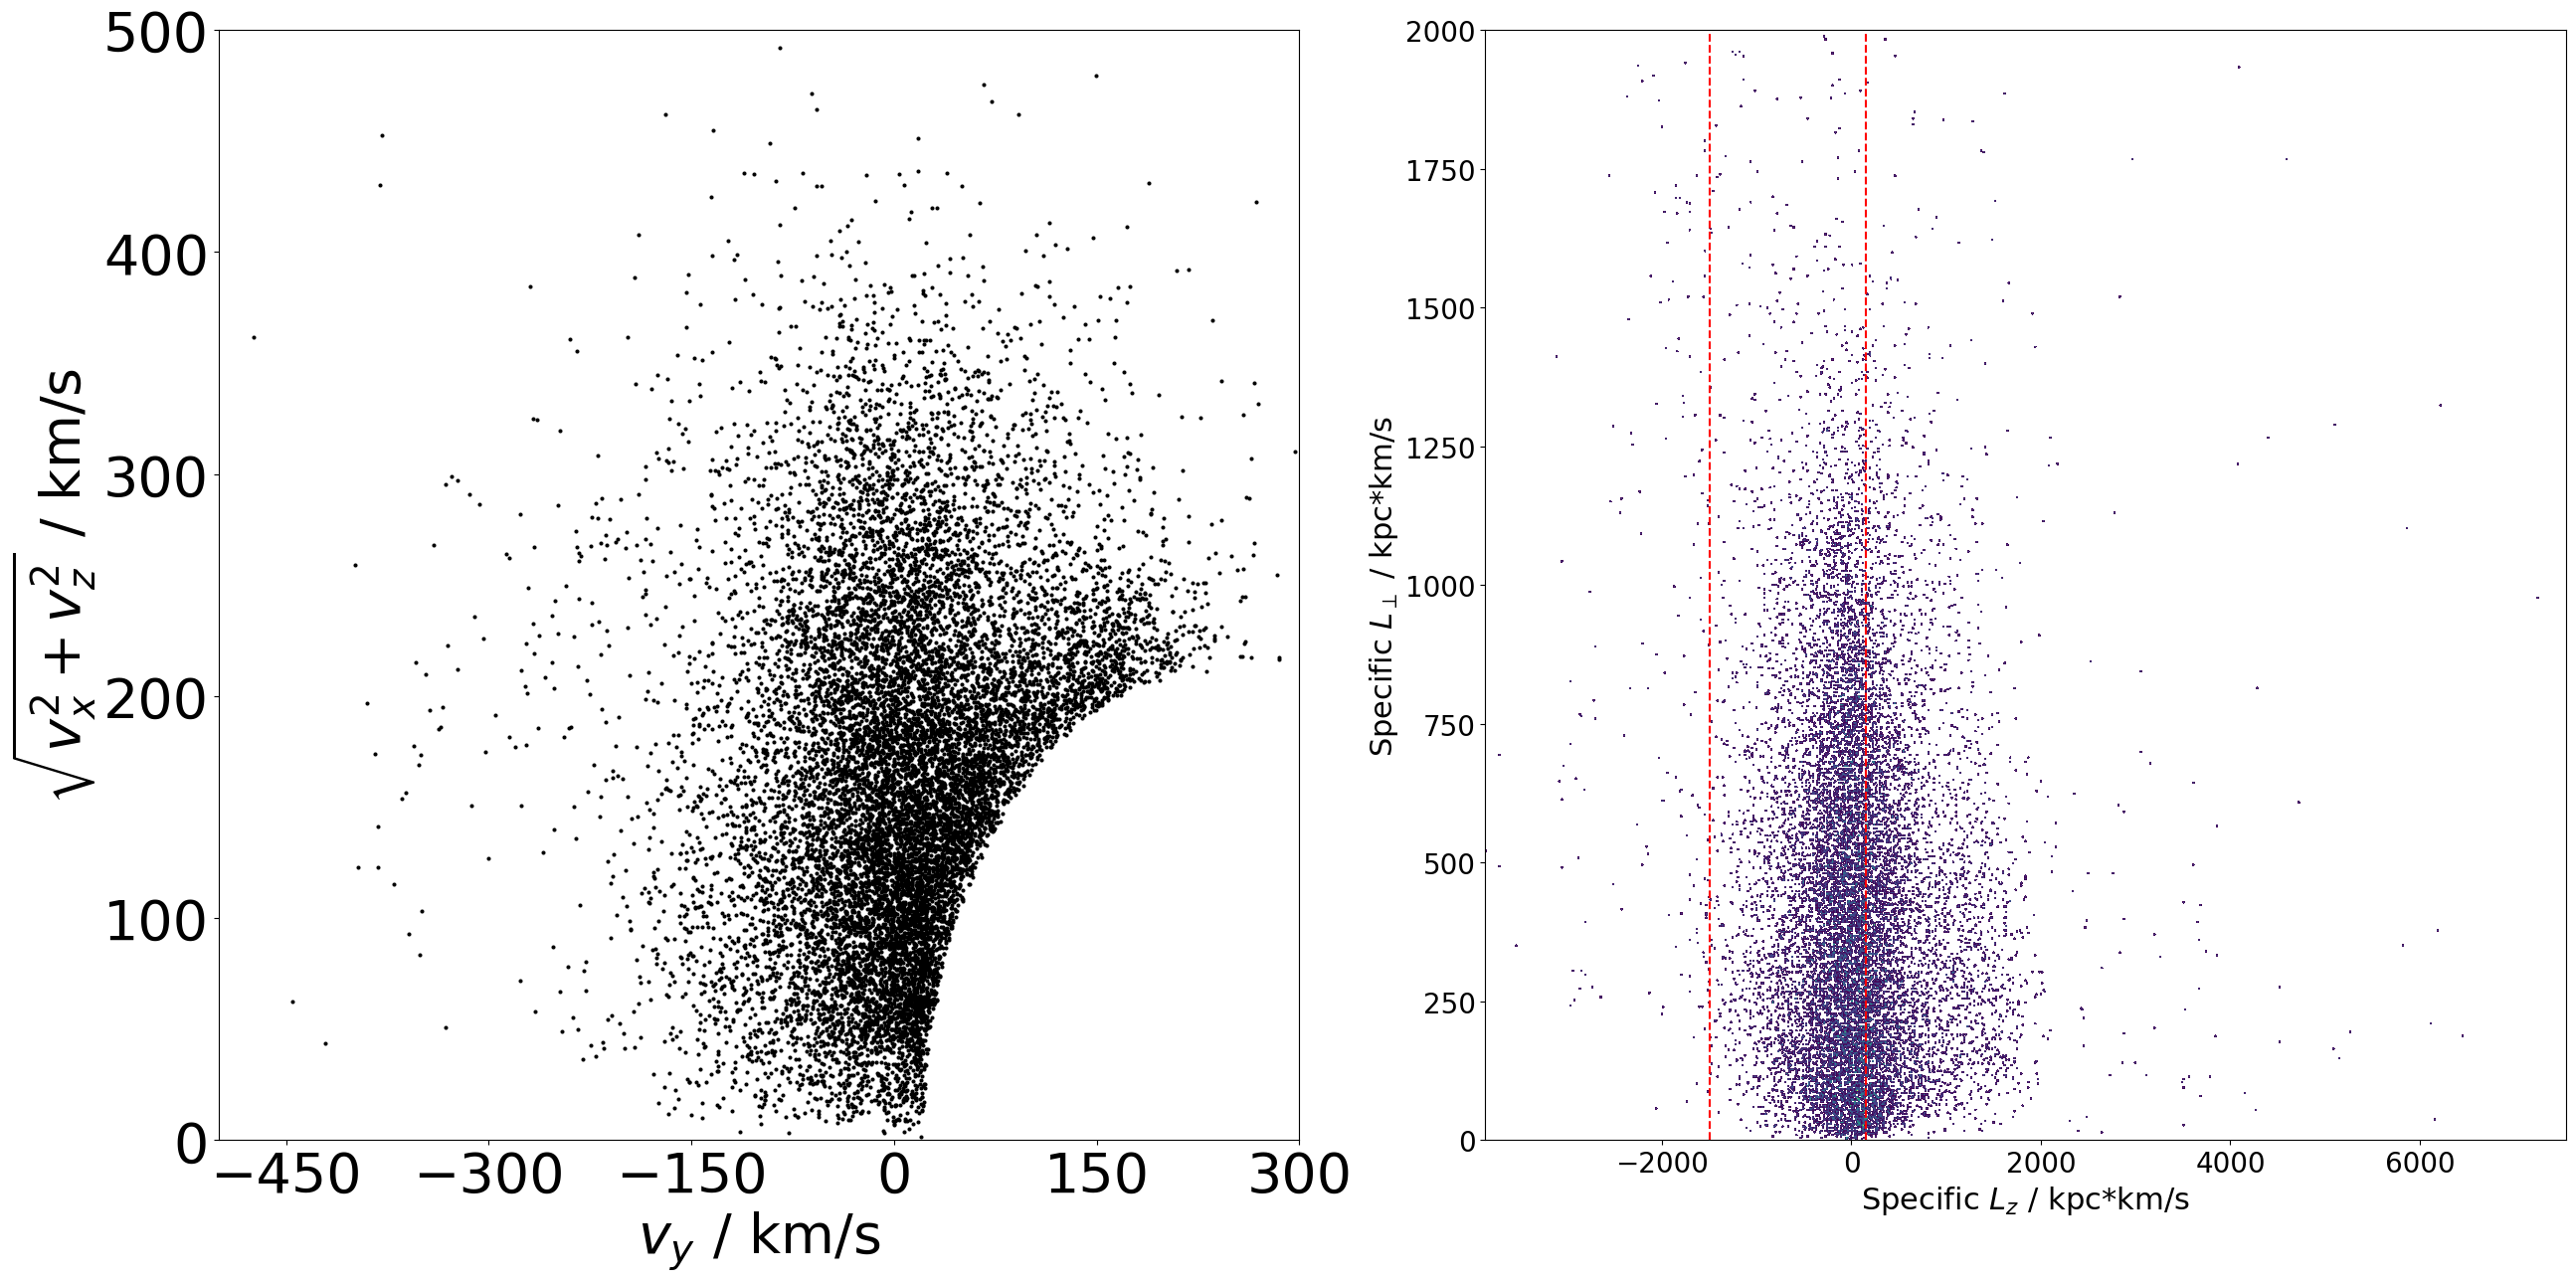

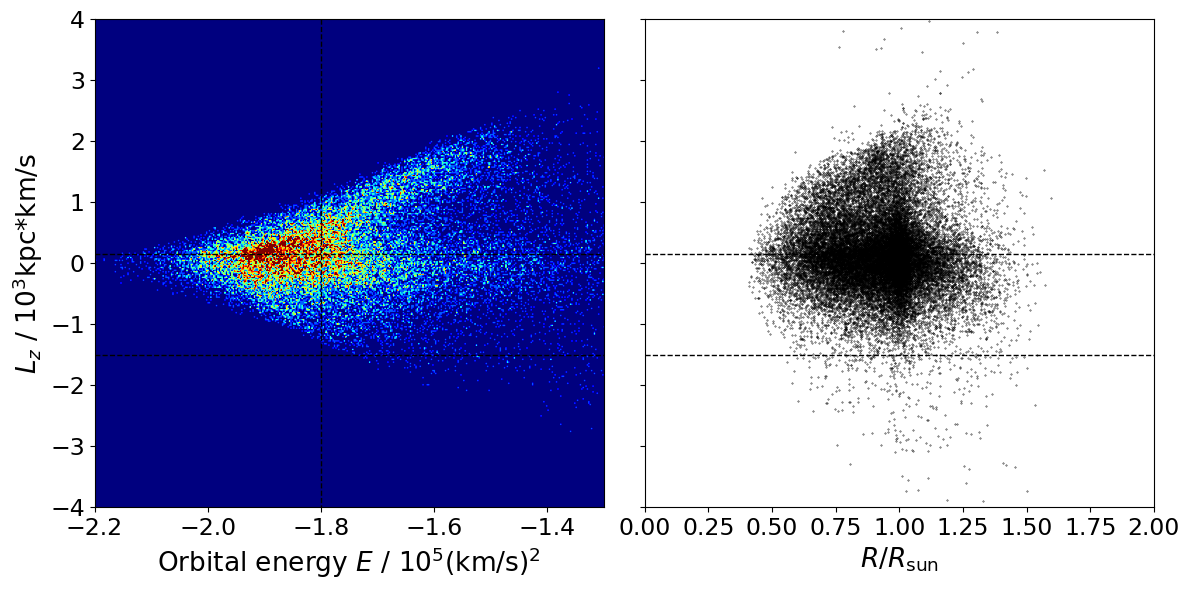

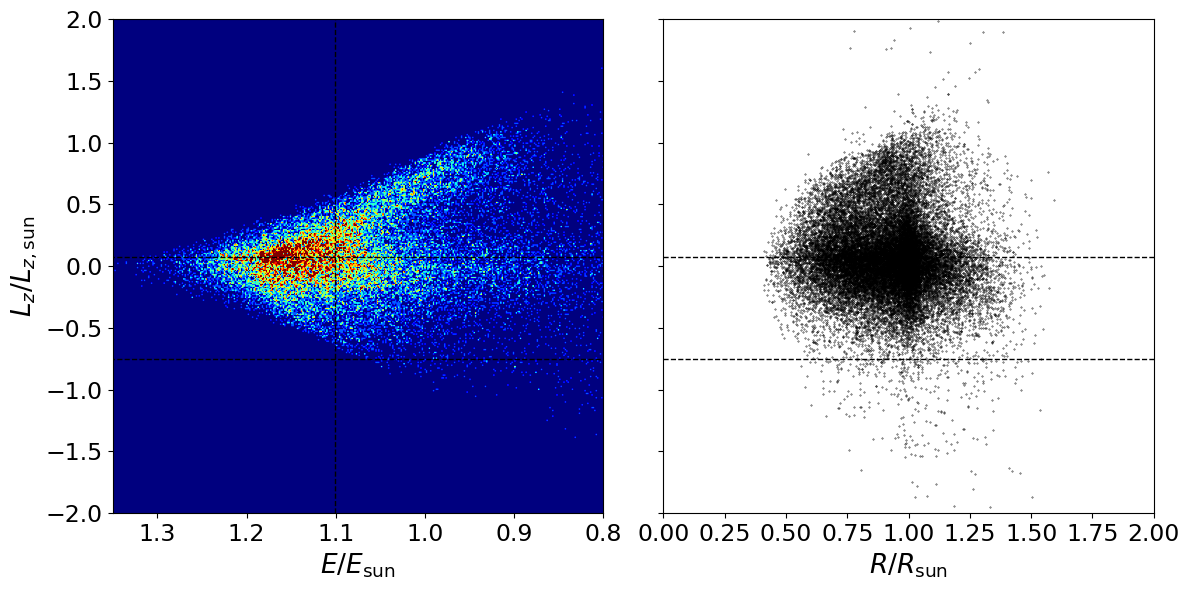

In [4]:
# repeat plots of Helmi et al. (2018) showing Gaia-Enceladus hints
# which potential?
orb_E_ge = orb_E_H17

# Fig. 1a of Helmi et al. (2018), right figure not in Helmi et al. (2018), own production out of interest
paral_cond = (paral_ge >= 0.4) & cond_v
ge_selection = (np.array(orb_E_ge) > -180000) & (L_z_ge < 150) #& (L_z_ge > -1500)

fig1=plt.figure(figsize=(13,11))
ax = fig1.add_subplot(1,1,1)
plt.scatter(np.array(v_y_ge[paral_cond & (ge_selection==False)]),np.array(v_zx_ge[paral_cond & (ge_selection==False)]),marker='.',s=3,color='black')
plt.scatter(np.array(v_y_ge[paral_cond & ge_selection]),np.array(v_zx_ge[paral_cond & ge_selection]),marker='o',c='None',edgecolors='blue',s=50,linewidth=1.5)
plt.xlabel('$v_y$ / km/s',size=50)
plt.ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=50)
plt.xticks([-450,-300,-150,0,150,300],size=30)
plt.yticks(size=30)
plt.xlim(-500,300)
plt.ylim(0,500)
plt.subplots_adjust(left=0.16,top=0.98,bottom=0.12,right=0.97)
plt.savefig('figures/A_01a_helmi18_fig1.png',format='png')

fig1=plt.figure(figsize=(26,13))
ax = fig1.add_subplot(1,2,1)
plt.scatter(np.array(v_y_ge[paral_cond]),np.array(v_zx_ge[paral_cond]),marker='.',s=15,color='black')
plt.xlabel('$v_y$ / km/s',size=40)
plt.ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=40)
plt.xticks([-450,-300,-150,0,150,300],size=40)
plt.yticks(size=40)
plt.xlim(-500,300)
plt.ylim(0,500)
ax = fig1.add_subplot(1,2,2, projection='scatter_density')
density = ax.scatter_density(np.array(L_z_ge[paral_cond]),np.array(L_perp_ge[paral_cond]), cmap=white_viridis)
plt.axvline(-1500,linestyle='dashed',color='red')
plt.axvline(150,linestyle='dashed',color='red')
plt.xlabel('Specific $L_z$ / kpc*km/s',size=22)
plt.ylabel('Specific $L_{\perp}$ / kpc*km/s',size=22)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylim(0,2000)
plt.tight_layout()
plt.savefig('figures/A_01b_helmi18_v_L.png',format='png')

# Extended Data Fig. 1a of Helmi et al. (2018), but unscaled
paral_cond = (paral_ge >= 0.2)
bprp_excess_cond = (bprp_excess < 1.27)

fig3=plt.figure(figsize=(12,6))
ax = fig3.add_subplot(1, 2, 1, projection='scatter_density')
density = ax.scatter_density(np.array(orb_E_ge[paral_cond & bprp_excess_cond])/100000,np.array(L_z_ge[paral_cond & bprp_excess_cond]/1000), cmap=plt.cm.jet,vmax=4.5,vmin=0)
plt.ylabel('$L_z$ / $10^3$kpc*km/s',size=19)
plt.xlabel('Orbital energy $E$ / $10^5$(km/s)$^2$',size=19)
plt.xlim(-2.2,-1.3)
plt.ylim(-4,4)
plt.hlines(-1.5,np.min(np.array(orb_E_H17)),-0.5,linestyle='dashed',color='black',lw=1)
plt.hlines(0.15,np.min(np.array(orb_E_H17))/100000,-0.5,linestyle='dashed',color='black',lw=1)
plt.vlines(-1.8,-3700,8700,linestyle='dashed',color='black',lw=1)
plt.xticks(size=17)
plt.yticks(size=17)
ax = fig3.add_subplot(1, 2, 2)
plt.scatter(np.array(R_ge[paral_cond & bprp_excess_cond]/R_sun),np.array(L_z_ge[paral_cond & bprp_excess_cond]/(-L_z_sun)),marker='.',s=0.4,color='black')
plt.xlabel('$R/R_\mathrm{sun}$',size=19)
plt.xlim(0,2)
plt.ylim(-2,2)
plt.hlines(-1500/np.array(-L_z_sun),0,2,linestyle='dashed',color='black',lw=1)
plt.hlines(150/np.array(-L_z_sun),0,2,linestyle='dashed',color='black',lw=1)
plt.xticks(size=12)
plt.tick_params(labelleft=False)
plt.xticks(size=17)
plt.tight_layout()
plt.savefig('figures/A_01c_helmi18_ext_fig1a_1b.png',format='png')

# Extended Data Fig. 1a and 1b of Helmi et al. (2018) scaled
fig3=plt.figure(figsize=(12,6))
ax = fig3.add_subplot(1, 2, 1, projection='scatter_density')
density = ax.scatter_density(np.array(orb_E_ge[paral_cond & bprp_excess_cond]/orb_E_sun),np.array(L_z_ge[paral_cond & bprp_excess_cond]/(-L_z_sun)), cmap=plt.cm.jet,vmax=4.5,vmin=0)
plt.ylabel('$L_z/L_{z,\mathrm{sun}}$',size=19)
plt.xlabel('$E/E_\mathrm{sun}$',size=19)
plt.xlim(1.35,0.8)
plt.ylim(-2,2)
plt.hlines(-1500/np.array(-L_z_sun),np.array(np.min(orb_E_H17)/orb_E_sun),-50000/np.array(orb_E_sun),linestyle='dashed',color='black',lw=1)
plt.hlines(150/np.array(-L_z_sun),np.array(np.min(orb_E_H17)/orb_E_sun),-50000/np.array(orb_E_sun),linestyle='dashed',color='black',lw=1)
plt.vlines(-180000/np.array(orb_E_sun),-2,2,linestyle='dashed',color='black',lw=1)
plt.xticks(size=17)
plt.yticks(size=17)
ax = fig3.add_subplot(1, 2, 2)
plt.scatter(np.array(R_ge[paral_cond & bprp_excess_cond]/R_sun),np.array(L_z_ge[paral_cond & bprp_excess_cond]/(-L_z_sun)),marker='.',s=0.4,color='black')
plt.xlabel('$R/R_\mathrm{sun}$',size=19)
plt.xlim(0,2)
plt.ylim(-2,2)
plt.hlines(-1500/np.array(-L_z_sun),0,2,linestyle='dashed',color='black',lw=1)
plt.hlines(150/np.array(-L_z_sun),0,2,linestyle='dashed',color='black',lw=1)
plt.xticks(size=17)
plt.tick_params(labelleft=False)
plt.tight_layout()
plt.savefig('figures/A_01d_helmi18_ext_fig1a_1b_scaled.png',format='png')

## A1.2. Reproduction of Lövdal et al. (2022), Ruiz-Lara et al. (2022)

In [5]:
# enter path of table to be used:
# for now enter the table I downloaded from Gaia, as 4MOST input catalogue does not contain all parameters yet
path='data/catalogues/lovdal22_substructure_xmatch.fits'
hdu_list = fits.open(path, memmap=True)
data_rv = Table(hdu_list[1].data)
hdu_list.close()
data_rv

source_id,ra,dec,parallax,parallax_error,pmra,pmdec,radial_velocity,radial_velocity_error,l,b,astrometric_params_solved,nu_eff_used_in_astrometry,pseudocolour,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ecl_lat,table2_oid,GaiaEDR3,x,y,z,vx,vy,vz,E,Lperp,Lz,signi,Labelorig,LabelDcut,D
int64,float64,float64,float64,float32,float64,float64,float32,float32,float64,float64,int16,float32,float32,float32,float32,float32,float64,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64
8766029055104,44.995945313391665,0.287857894817287,0.8428753391578824,0.026379768,33.99145021718314,-4.892459087269312,159.92522,9.263341,176.64284005471214,-48.70544690251177,31,1.5387814,nan,14.691891,15.054141,14.157354,-16.059649404937378,1,8766029055104,nan,nan,nan,-203.2152598485801,-138.20828314532133,-46.44233553208916,-124507.61103835865,205.12218099917575,949.2354519289232,0.0,0,0,0.0
72194106084096,44.69089046769776,0.4096508263480147,0.5896292377245224,0.061983246,19.37757052512318,-13.291082153698255,nan,nan,176.18719435265837,-48.83852926596789,31,1.5499108,nan,16.00585,16.335377,15.499504,-15.85373110287598,2,72194106084096,nan,nan,nan,-126.92500367238043,-172.15273509348896,-78.22144654667869,-135119.49714931115,522.0752232802408,668.2255259055784,0.0,0,0,0.0
113872468706688,44.99581359257321,0.8411298334991831,0.6561711426302779,0.044960164,29.83734458564876,-14.93245473837113,nan,nan,176.045842332752,-48.31853359094151,31,1.5541146,nan,15.991982,16.325039,15.47908,-15.53050729584283,3,113872468706688,nan,nan,nan,-235.01639642293514,-206.68416022851002,-133.3147641479786,-114027.01551961144,910.1758469502623,337.06409302814933,0.0,0,0,0.0
116930485416320,45.240698255431056,0.8654855573050629,1.4097277287256844,0.042353198,65.51146407260524,-67.60134071842872,nan,nan,176.27747254868623,-48.12687330151874,31,1.4628843,nan,15.500675,16.052172,14.796607,-15.578550036852265,4,116930485416320,nan,nan,nan,-94.71065830794208,-307.2809019379723,-85.75054160674713,-143315.82729513862,637.6695525348356,-541.9725115244971,0.0,0,0,0.0
134350872765184,45.100085948919485,1.0126847469841829,0.40630282947646107,0.027166648,32.63096810201513,-2.7178648818753373,nan,nan,175.97255903547307,-48.123810607625764,31,1.6250131,nan,14.875728,15.070472,14.538811,-15.39680852047279,5,134350872765184,nan,nan,nan,-337.6376163349301,-255.3650637442155,1.7755797056965719,-90126.99839376431,662.8087894487196,-137.07308588399792,0.0,0,0,0.0
143043886448000,45.79756662647656,0.6999460753917214,0.634625916715672,0.055879522,6.225102636118924,-47.56892500698377,nan,nan,177.03436690303795,-47.84262418113894,31,1.5345291,nan,16.572649,16.942413,16.028719,-15.898232275676426,6,143043886448000,nan,nan,nan,181.84521004568205,-290.7541691415427,-91.31434589491232,-124304.33656257526,996.8975458303681,-411.5965436414811,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6914409197757803008,311.8008436996004,-4.495597162072117,3.1946789855253024,0.016635189,138.0086183331538,-127.68405334227486,114.84582,3.4969509,42.70163100389417,-27.716308966762465,31,1.5853219,nan,12.621903,12.897459,12.177105,12.926585086329766,51665,6914409197757803008,nan,nan,nan,30.324365819396547,-65.92218903605021,-291.8593944869525,-99113.34284207356,2282.3067323641544,1440.2265744422223,9.825504224929457,60,60,1.964795871102681
6915476101993111168,315.8381425423444,-3.575854441718444,0.5105066702366323,0.017103482,19.67103695833692,-10.304512354334241,-56.931572,0.82457376,45.86175050904909,-30.793189561677654,31,1.4694843,nan,12.354402,12.88849,11.6619625,12.671646796779388,51666,6915476101993111168,nan,nan,nan,-109.91213672360428,-103.32033904567608,-142.37130386608334,-135819.05440666064,859.1066476086481,885.9053237770255,2.136276059316544,0,0,2.3032879309491245


In [6]:
ra_rv = data_rv['ra'] # in deg
dec_rv = data_rv['dec'] # in deg
paral_rv = data_rv['parallax'] # in mas
paral_e_rv = data_rv['parallax_error'] # in mas
Gmag_rv = data_rv['phot_g_mean_mag'] # in mag
BP_rv = data_rv['phot_bp_mean_mag'] # in mag
RP_rv = data_rv['phot_rp_mean_mag'] # in mag
bprp_rv = BP_rv - RP_rv # in mag
pmra = data_rv['pmra'] # in mas/yr
pmdec = data_rv['pmdec'] # in mas/y
rad_vel_gaia = data_rv['radial_velocity'] # in km/s
rad_vel_gaia_e = data_rv['radial_velocity_error'] # in km/s
source = data_rv['source_id']
astr_par_sol = data_rv['astrometric_params_solved']
ecl_lat = data_rv['ecl_lat']
pseudocolour = data_rv['pseudocolour']
nu_eff = data_rv['nu_eff_used_in_astrometry']
vx=data_rv['vx']
vy=data_rv['vy']
vz=data_rv['vz']
Lz=data_rv['Lz']
Lperp=data_rv['Lperp']
E=data_rv['E']
sourceid=data_rv['GaiaEDR3']

# use the script by Lindegren et al. (2021) to compute zero-points of the parallax
zpt.load_tables()
valid = astr_par_sol > 3
zp=np.empty(shape=len(Gmag_rv))
zp[valid] = zpt.get_zpt(Gmag_rv[valid], nu_eff[valid], pseudocolour[valid], ecl_lat[valid], astr_par_sol[valid],_warnings=False)
zp[valid==False] = 0

paral0_rv = paral_rv - zp # in mas

num=0
for i in range(len(data_rv)):
    if sourceid[i] == source[i]:
        pass
    else:
        num=num+1
print('Number of non-matching source IDs for crossmatch is',num)

Number of non-matching source IDs for crossmatch is 0


In [7]:
# radial velocity to use (for experimentation with GALAH, APOGEE, RAVE)
cond_ana=(np.isnan(rad_vel_gaia)==False)
rad_vel=rad_vel_gaia
rad_vel_e=rad_vel_gaia_e

# distances from parallaxes, only if relative error >3
no_paral = (np.isnan(paral0_rv) == True)
paral_bet3rv = (paral0_rv >= 3*paral_e_rv)
paral_wor3rv = (paral0_rv < 3*paral_e_rv)

dist_rv = np.empty(shape=(len(ra_rv)))
dist_rv[paral_bet3rv] = 1000/paral0_rv[paral_bet3rv]
dist_rv[no_paral] = np.nan
dist_rv[paral_wor3rv] = np.nan
#dist_rv[paral_wor3 & (distph>10*distph_e)] = distph[paral_wor3 & (distph>10*distph_e)]

# I want to filter out stars with unreliable radial velocities as well (more than 10 km/s)
print('The percentage of objects removed due to distance and radial velocity is '+str(round(100*(len(ra_rv[cond_ana & (np.isnan(dist_rv)==True)]) + len(ra_rv[cond_ana & (rad_vel_e>10)]) - len(ra_rv[cond_ana & (np.isnan(dist_rv)==True) & (rad_vel_e>10)]))/len(ra_rv[cond_ana]),2))+'%')
rad_vel[(rad_vel_e>10)] = np.nan
rad_vel_e[(rad_vel_e>10)] = np.nan
print('The number of objects left to do analyses with is '+str(len(ra_rv[cond_ana & (np.isnan(dist_rv)==False) & (np.isnan(rad_vel)==False)]))+', or '+str(round(100*len(ra_rv[cond_ana & (np.isnan(dist_rv)==False) & (np.isnan(rad_vel)==False)])/len(ra_rv[cond_ana]),2))+'%')

# add Sun parameters to set astropy transformation scale following plots by Sun
r_gc_sun=np.array([8122,0,20.8])*u.pc
v_gc_sun=np.array([-11.1,12.24+232.8,7.25])*u.km/u.s

# using astropy get full cartesian coordinates for position and velocity
astrom=ICRS(ra=ra_rv*u.degree,dec=dec_rv*u.degree,distance=dist_rv*u.pc,pm_ra_cosdec=pmra*np.cos((dec_rv/360)*2*np.pi)*u.mas/u.yr,pm_dec=pmdec*u.mas/u.yr,radial_velocity=rad_vel*u.km/u.s)
# convert to galactocentric coordinates, define own parameters
gc_frame = coord.Galactocentric(galcen_distance=r_gc_sun[0],galcen_v_sun=v_gc_sun,z_sun=r_gc_sun[2])
gc=coord.SkyCoord(astrom).transform_to(gc_frame)

#NOTE: astropy is right-handed, galpy and kinematic analyses in general left-handed
# for now I put -gc.x and -gc.v_x instead of gc.x and gc.v_x as solution; maybe better solution later
gcx=-gc.x
gcvx=-gc.v_x

# position and velocity vectors
r_gc=np.transpose(np.array([gcx,gc.y,gc.z]))*u.pc # in pc
v_gc=np.transpose(np.array([gcvx,gc.v_y,gc.v_z]))*u.km/u.s # in km/s

# determine GC velocities via Johnson & Soderblom (1987) instead of using the astropy velocities
ra_rad=(ra_rv/360)*2*np.pi
dec_rad=(dec_rv/360)*2*np.pi

alphag=(192.85948/360)*2*np.pi
deltag=(27.12825/360)*2*np.pi
l_ngp=(122.93192/360)*2*np.pi
k=4.74057

t1=np.array([[np.cos(l_ngp),np.sin(l_ngp),0],[np.sin(l_ngp),-np.cos(l_ngp),0],[0,0,1]])
t2=np.array([[-np.sin(deltag),0,np.cos(deltag)],[0,-1,0],[np.cos(deltag),0,np.sin(deltag)]])
t3=np.array([[np.cos(alphag),np.sin(alphag),0],[np.sin(alphag),-np.cos(alphag),0],[0,0,1]])
T=t1.dot(t2.dot(t3))
A=np.array([[np.cos(ra_rad)*np.cos(dec_rad),-np.sin(ra_rad),-np.cos(ra_rad)*np.sin(dec_rad)],[np.sin(ra_rad)*np.cos(dec_rad),np.cos(ra_rad),-np.sin(ra_rad)*np.sin(dec_rad)],[np.sin(dec_rad),np.zeros(len(ra_rad)),np.cos(dec_rad)]])
B=np.transpose(T.dot(np.transpose(A,axes=(1,0,2))),axes=(2,0,1))
icrs_vel=np.transpose(np.array([rad_vel_gaia,k*pmra*np.cos(dec_rad)/paral0_rv,k*pmdec/paral0_rv]))
v_gc = np.transpose(np.einsum('ijk,ik->ij',B,icrs_vel))
v_gc = np.transpose([-v_gc[0],v_gc[1]+232.8,v_gc[2]])*u.km/u.s

# radial distances r and cylindrical distances R
rad=np.sqrt(np.transpose(r_gc)[0]**2+np.transpose(r_gc)[1]**2+np.transpose(r_gc)[2]**2) # in pc
R=np.sqrt(np.transpose(r_gc)[0]**2+np.transpose(r_gc)[1]**2) # in pc
z=np.transpose(r_gc)[2]

# absolute space velocities and zx-component of velocity
v_tot=np.sqrt(np.transpose(v_gc)[0]**2+np.transpose(v_gc)[1]**2+np.transpose(v_gc)[2]**2) # in km/s
v_zx=np.sqrt(np.transpose(v_gc)[0]**2+np.transpose(v_gc)[2]**2) # in km/s

# specific angular momentum L=rxv
L=np.cross(r_gc,v_gc) # specific angular momentum in pc*km/s
L_x=np.transpose(L)[0]
L_y=np.transpose(L)[1]
L_z=np.transpose(L)[2]
L_perp=np.sqrt(L_x**2+L_y**2)

# energy using GalPot
G=4.3*10**(-3)*u.pc/u.Msun*(u.km/u.s)**2
r_cut=3500*u.pc # see Zhu et al. (2022), Sotillo-Ramos et al. (2023), Chen et al. (2023)
r_disk=6*2500*u.pc # Binney & Tremaine (2008), p. 18
r_halo=300000*u.pc

# potentials and circular velocity using GalPot
Phi_M17 = GalaxyPotential("data/catalogues/PJM17_best.Tpot")

# potential in km^2/s^2
Phi_MM17=Phi_M17.Potential(np.array(R)/1000,np.array(z)/1000)*Phi_M17.kpc_Myr_to_km_s**2*(u.km/u.s)**2
orb_E_MM17=v_tot**2/2+Phi_MM17

# energy using standard GALA potential (Hernquist bulge, Miyamoto-Nagai disk, NFW halo)
# model parameters (from Naidu et al. 2020)
M_halo=5.4*10**11*u.Msun
a_h=15620*u.pc
G=4.3*10**(-3)*u.pc/u.Msun*(u.km/u.s)**2
M_disk=6.8*10**10*u.Msun
a_d=3000*u.pc
b_d=280*u.pc
M_bulge=0.67*10**10*u.Msun
c_b=1000*u.pc

usys1=UnitSystem(u.pc,u.Myr,u.Msun,u.degree)
usys2=UnitSystem(u.km,u.s,u.kg,u.degree)
mwp=gp.MilkyWayPotential(disk={'m':M_disk,'a':a_d,'b':b_d},bulge={'m':M_bulge,'c':c_b},halo={'m':M_halo,'r_s':a_h},units=usys1)
phi_gala=mwp.energy([np.transpose(r_gc)[0],np.transpose(r_gc)[1],np.transpose(r_gc)[2]]).decompose(usys2)
orb_E_gala = v_tot**2/2 + phi_gala

The percentage of objects removed due to distance and radial velocity is 2.33%
The number of objects left to do analyses with is 24912, or 97.67%


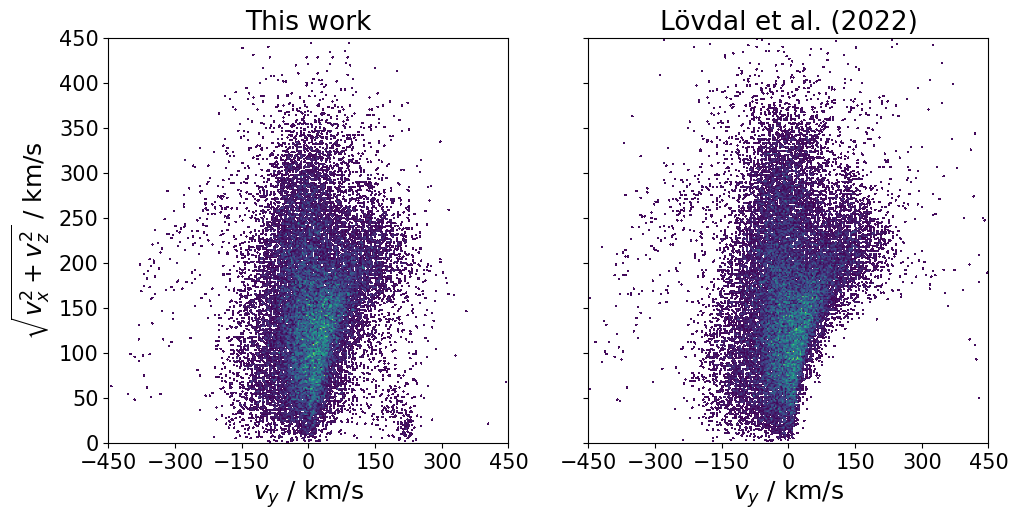

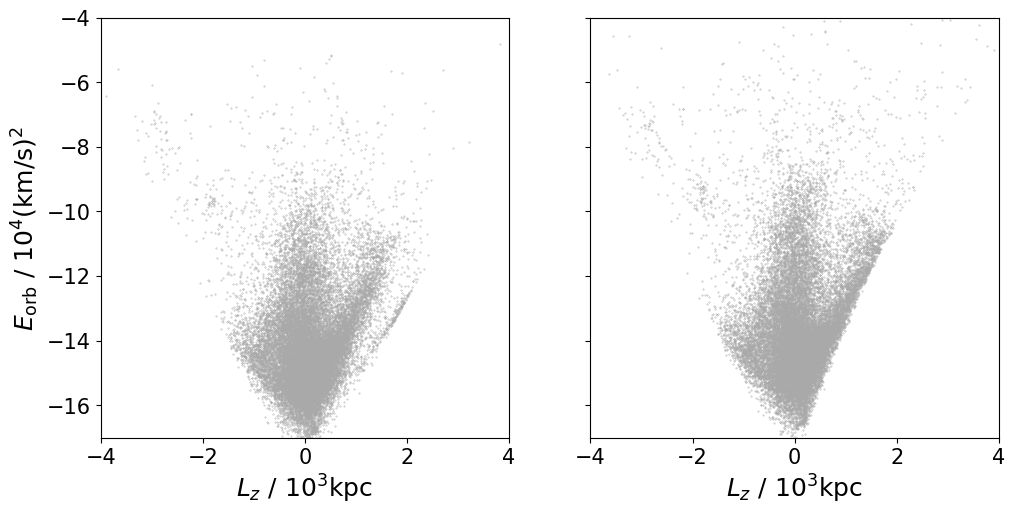

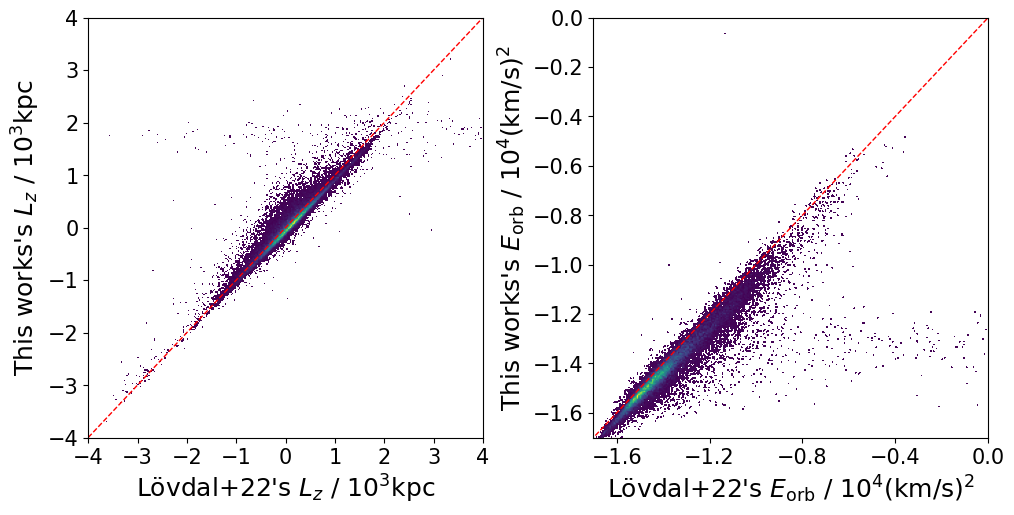

In [8]:
nans=(np.isnan(L_z)==False) & (np.isnan(orb_E_gala)==False)

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1, projection='scatter_density')
nan=(np.isnan(v_zx)==False)
density = ax.scatter_density(np.array(np.transpose(v_gc)[1][nan]),np.array(v_zx[nan]), cmap=white_viridis)
plt.xlabel('$v_y$ / km/s',size=18)
plt.ylabel('$\sqrt{v_x^2+v_z^2}$ / km/s',size=18)
plt.title('This work',size=19)
plt.xlim(-450,450)
plt.ylim(0,450)
plt.xticks([-450,-300,-150,0,150,300,450],size=15)
plt.yticks(size=15)
ax = fig.add_subplot(1, 2, 2, projection='scatter_density')
nan=(np.isnan(v_zx)==False)
density = ax.scatter_density(np.array(vy[nan]+232.8),np.array(np.sqrt(vx[nan]**2+vz[nan]**2)), cmap=white_viridis)
plt.xlabel('$v_y$ / km/s',size=18)
plt.title('Lövdal et al. (2022)',size=19)
plt.xlim(-450,450)
plt.ylim(0,450)
plt.xticks([-450,-300,-150,0,150,300,450],size=15)
plt.tick_params(axis='y',which='both',bottom=False,top=False,labelleft=False)
plt.subplots_adjust(left=0.1,top=0.94,bottom=0.13,right=0.98)
plt.savefig('figures/A_02a_lovdal_v.png',format='png')

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=True)
axs[0].scatter(L_z[nans]/1000000,orb_E_gala[nans]/10000,color='darkgray',s=0.1)
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-17,-4)
axs[0].set_xlabel('$L_z$ / $10^3$kpc',size=18)
axs[0].set_ylabel('$E_\mathrm{orb}$ / $10^4$(km/s)$^2$',size=18)
axs[0].tick_params(axis='both',labelsize=15)
#axs[0].set_title('This work')
axs[1].scatter(Lz[nans]/1000,E[nans]/10000,color='darkgray',s=0.1)
axs[1].set_xlabel('$L_z$ / $10^3$kpc',size=18)
#axs[1].set_title('Lövdal et al. (2022)')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-17,-4)
axs[1].tick_params(axis='x',labelsize=15)
plt.subplots_adjust(left=0.092,top=0.97,bottom=0.13,right=0.99)
plt.savefig('figures/A_02b_lovdal_orbE_Lz.png',format='png')

def lin(x):
    return x

fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1, projection='scatter_density')
nan=(np.isnan(L_z)==False)
density = ax.scatter_density(np.array(Lz[nan])/1000,np.array(L_z[nan])/1000000, cmap=white_viridis)
plt.plot(np.linspace(-4,4,10),lin(np.linspace(-4,4,10)),lw=1,ls='dashed',color='red')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Lövdal+22\'s $L_z$ / $10^3$kpc',size=18)
plt.ylabel('This works\'s $L_z$ / $10^3$kpc',size=18)
ax = fig.add_subplot(1, 2, 2, projection='scatter_density')
nan=(np.isnan(orb_E_gala)==False)
density = ax.scatter_density(np.array(E[nan])/100000,np.array(orb_E_gala[nan])/100000, cmap=white_viridis)
plt.plot(np.linspace(-4,4,10),lin(np.linspace(-4,4,10)),lw=1,ls='dashed',color='red')
plt.xlim(-1.7,0)
plt.ylim(-1.7,0)
plt.xticks([-1.6,-1.2,-0.8,-0.4,0],size=15)
plt.yticks(size=15)
plt.xlabel('Lövdal+22\'s $E_\mathrm{orb}$ / $10^4$(km/s)$^2$',size=18)
plt.ylabel('This works\'s $E_\mathrm{orb}$ / $10^4$(km/s)$^2$',size=18)
plt.subplots_adjust(wspace=0.28,left=0.08,top=0.97,bottom=0.13,right=0.98)
plt.savefig('figures/A_02c_lovdal_direct.png',format='png')

## A2. Concerning GSP-Spec abundances

In [9]:
# enter path of table to be used:
# for now enter the table I downloaded from Gaia, as 4MOST input catalogue does not contain all parameters yet
path='data/kinematic_analysis_plus_galah_gspspec.fits'

hdu_list = fits.open(path, memmap=True)
evt_data = Table(hdu_list[1].data)
evt_data

sourceid,ra,dec,gaiag,gaiabp,gaiarp,parallax,parallax0,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,rv_galah,rv_galah_e,rv_apogee,rv_apogee_e,rv_rave,rv_rave_e,FeHphot_gen,ruwe,phot_bp_rp_excess_factor,distance,x_gc,y_gc,z_gc,vx_gc,vy_gc,vz_gc,rad_gc,R_gc,v_tot,vzx_gc,L_z,L_perp,cond_v,cond_z,Phi_MM17,orb_E_MM17,lamb_z,lamb_z2,cond_halo,phi_gala,orb_E_gala,bp_rp0,M_G,A_G,sobject_id,flag_sp,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,fe_h_atmo,vmic,vbroad,e_vbroad,chi2_sp,alpha_fe,e_alpha_fe,nr_alpha_fe,flag_alpha_fe,Li_fe,e_Li_fe,nr_Li_fe,flag_Li_fe,C_fe,e_C_fe,nr_C_fe,flag_C_fe,O_fe,e_O_fe,nr_O_fe,flag_O_fe,Na_fe,e_Na_fe,nr_Na_fe,flag_Na_fe,Mg_fe,e_Mg_fe,nr_Mg_fe,flag_Mg_fe,Al_fe,e_Al_fe,nr_Al_fe,flag_Al_fe,Ca_fe,e_Ca_fe,nr_Ca_fe,flag_Ca_fe,Sr_fe,e_Sr_fe,nr_Sr_fe,flag_Sr_fe,Y_fe,e_Y_fe,nr_Y_fe,flag_Y_fe,Zr_fe,e_Zr_fe,nr_Zr_fe,flag_Zr_fe,Mo_fe,e_Mo_fe,nr_Mo_fe,flag_Mo_fe,Ru_fe,e_Ru_fe,nr_Ru_fe,flag_Ru_fe,Ba_fe,e_Ba_fe,nr_Ba_fe,flag_Ba_fe,La_fe,e_La_fe,nr_La_fe,flag_La_fe,Ce_fe,e_Ce_fe,nr_Ce_fe,flag_Ce_fe,Nd_fe,e_Nd_fe,nr_Nd_fe,flag_Nd_fe,Sm_fe,e_Sm_fe,nr_Sm_fe,flag_Sm_fe,Eu_fe,e_Eu_fe,nr_Eu_fe,flag_Eu_fe,ebv,source_id,teff_gspspec,logg_gspspec,mh_gspspec,alphafe_gspspec,flags_gspspec
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,int64,int64,float32,float64,float32,float64,float32,float64,int64,float32,float32,float32,float64,float32,float64,float64,float64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,int64,int64,float64,int64,float32,float32,float32,float32,str41
1004202009188352,46.15924689297299,2.6132294365595676,14.58080005645752,14.989568710327148,14.0015287399292,1.550731292067137,1.594498292067137,0.0226069837808609,-11.609730622763763,0.02362423576414585,-0.5760674922316876,0.022171128541231155,-34.13906478881836,5.684811115264893,nan,nan,nan,nan,nan,nan,-0.6445037069714813,1.0484113693237305,1.215356469154358,627.1565200007719,8555.466149356958,34.77194258022526,-431.0851839484719,-54.905468244524,264.7833431467564,14.222298240823111,8566.390404166943,8555.53681079005,270.7897764288274,56.71758290337621,2267254.0989947813,150824.03079306806,False,False,-180579.68336239166,-143916.1318532045,1.1469255997669692,1.1962337853010632,False,-154027.17652670515,-117363.62501751799,0.8451147489974336,5.593920348400026,0.28578459408722806,999999,-9223372036854775808,nan,nan,nan,nan,nan,nan,-9223372036854775808,nan,nan,nan,nan,nan,nan,nan,nan,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-9223372036854775808,-9223372036854775808,nan,nan,-92233

Gaia DR3 GSP-Spec in 6D subset:
Number of objects with [M/H] in GSP-Spec: 88669
Number of objects with [alpha/Fe] in GSP-Spec: 87106
/tmp/ipykernel_7553/2117863359.py:18: RuntimeWarning: invalid value encountered in less
  clean_flag1to6 = (flags_num<10**35)

/tmp/ipykernel_7553/2117863359.py:19: RuntimeWarning: invalid value encountered in less
  clean_flag1to7 = (flags_num<2*10**34)

/tmp/ipykernel_7553/2117863359.py:20: RuntimeWarning: invalid value encountered in less
  clean_flag1to13 = (flags_num<10**28)



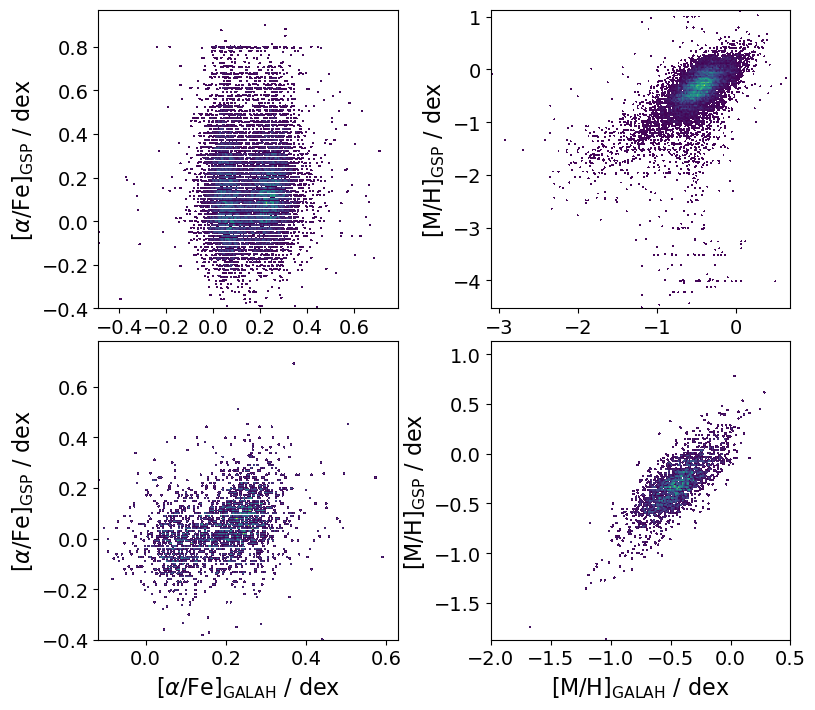

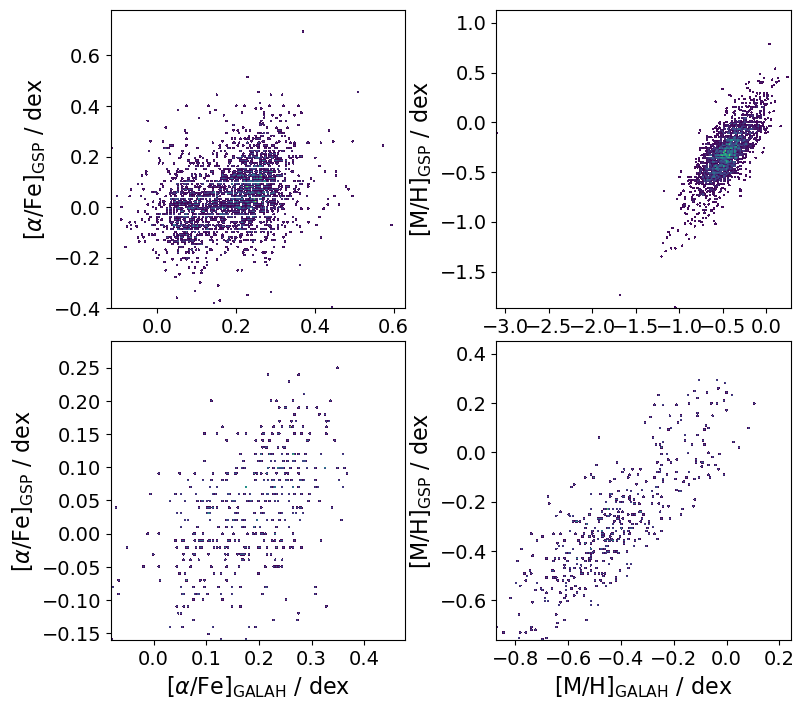

In [10]:
print('Gaia DR3 GSP-Spec in 6D subset:')
print('Number of objects with [M/H] in GSP-Spec:',len(evt_data[np.isnan(evt_data['mh_gspspec'])==False]))
print('Number of objects with [alpha/Fe] in GSP-Spec:',len(evt_data[np.isnan(evt_data['alphafe_gspspec'])==False]))

# loading of parameters and abundances in GSP-Spec
mh_gsp = evt_data['mh_gspspec']
alphafe_gsp = evt_data['alphafe_gspspec']
flags_gsp = evt_data['flags_gspspec']
cond_mhgsp = (np.isnan(mh_gsp)==False)
cond_alphafegsp = (np.isnan(alphafe_gsp)==False)

# in order to clean flags of GSP-Spec
flags_num=np.array(flags_gsp)
flags_num[(flags_gsp=='')]=np.nan
flags_num[(flags_gsp!='')]=list(map(int, np.array(flags_gsp[(flags_gsp!='')])))
flags_num=flags_num.astype(float)
clean_none = np.array([True]*len(flags_num))
clean_flag1to6 = (flags_num<10**35)
clean_flag1to7 = (flags_num<2*10**34)
clean_flag1to13 = (flags_num<10**28)
flags=clean_flag1to7

# loading of parameters and abundances in GALAH DR3
feh_galah = evt_data['fe_h']
alphafe_galah = evt_data['alpha_fe']
cond_fehgalah = (np.isnan(feh_galah)==False)
cond_alphafegalah = (np.isnan(alphafe_galah)==False)

# include flags of GALAH
flag_sp=evt_data['flag_sp']
flag_feh_galah=evt_data['flag_fe_h']
clean_none_galah = np.array([True]*len(flag_sp))
clean_flag_galah = (flag_sp==0) & (flag_feh_galah==0)
flags_galah = clean_flag_galah

# since the two [alpha/Fe] vs. [(M/Fe)/H] plots looked so different, want to know how many stars appear in both plots
# also plot those alpha abundances against each other
nancondgg = (np.isnan(alphafe_gsp)==False) & (np.isnan(mh_gsp)==False) & (np.isnan(alphafe_galah)==False) & (np.isnan(feh_galah)==False)

x1=np.linspace(-0.75,1.25,50)
x2=np.linspace(-3,0.6,50)
fig=plt.figure(figsize=(8,7))
ax = fig.add_subplot(2,2,1,projection='scatter_density')
density = ax.scatter_density(alphafe_galah[nancondgg & (alphafe_galah<1)],alphafe_gsp[nancondgg & (alphafe_galah<1)],cmap=white_viridis)
plt.ylabel(r'[$\alpha$/Fe]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,2,projection='scatter_density')
density = ax.scatter_density(feh_galah[nancondgg],mh_gsp[nancondgg],cmap=white_viridis)
plt.ylabel(r'[M/H]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,3,projection='scatter_density')
density = ax.scatter_density(alphafe_galah[nancondgg & flags & flags_galah & (alphafe_galah<1)],alphafe_gsp[nancondgg & flags & flags_galah & (alphafe_galah<1)],cmap=white_viridis)
plt.xlabel(r'[$\alpha$/Fe]$_\mathrm{GALAH}$ / dex',size=16)
plt.ylabel(r'[$\alpha$/Fe]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,4,projection='scatter_density')
density = ax.scatter_density(feh_galah[nancondgg & flags & flags_galah],mh_gsp[nancondgg & flags & flags_galah],cmap=white_viridis)
plt.xlabel(r'[M/H]$_\mathrm{GALAH}$ / dex',size=16)
plt.ylabel(r'[M/H]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-2,0.5)
plt.subplots_adjust(hspace=0.11,wspace=0.31,left=0.115,top=0.99,bottom=0.09,right=0.98)
plt.savefig('figures/A_03a_gspspec_galah_full.png',format='png')

fig=plt.figure(figsize=(8,7))
ax = fig.add_subplot(2,2,1,projection='scatter_density')
density = ax.scatter_density(alphafe_galah[nancondgg & clean_flag1to7 & flags_galah & (alphafe_galah<1)],alphafe_gsp[nancondgg & clean_flag1to7 & flags_galah & (alphafe_galah<1)],cmap=white_viridis)
plt.ylabel(r'[$\alpha$/Fe]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,2,projection='scatter_density')
density = ax.scatter_density(feh_galah[nancondgg & clean_flag1to7 & flags_galah],mh_gsp[nancondgg & clean_flag1to7 & flags_galah],cmap=white_viridis)
plt.ylabel(r'[M/H]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,3,projection='scatter_density')
density = ax.scatter_density(alphafe_galah[nancondgg & clean_flag1to13 & flags_galah],alphafe_gsp[nancondgg & clean_flag1to13 & flags_galah],cmap=white_viridis)
plt.xlabel(r'[$\alpha$/Fe]$_\mathrm{GALAH}$ / dex',size=16)
plt.ylabel(r'[$\alpha$/Fe]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
ax = fig.add_subplot(2,2,4,projection='scatter_density')
density = ax.scatter_density(feh_galah[nancondgg & clean_flag1to13 & flags_galah],mh_gsp[nancondgg & clean_flag1to13 & flags_galah],cmap=white_viridis)
plt.xlabel(r'[M/H]$_\mathrm{GALAH}$ / dex',size=16)
plt.ylabel(r'[M/H]$_\mathrm{GSP}$ / dex',size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.subplots_adjust(hspace=0.11,wspace=0.31,left=0.13,top=0.99,bottom=0.09,right=0.98)
plt.savefig('figures/A_03b_gspspec_galah_kin.png',format='png')